## Gradient Boosting Modeling ##

The models are:
- CatBoost
- LightGBM
- XGBoost
- HistGradientBoosting

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

# import warnings 
# warnings.filterwarnings('ignore')
from pandas import MultiIndex, Int16Dtype

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score

### Prepare data ###

In [3]:
df = pd.read_csv('../../data/data_clean/SASS_cleaned_v2.csv', sep=',', header=0)
print(df.shape)

(3640, 57)


In [4]:
cols_ren = {'label_Current_Teacher': 'label_Current',
'vacnc_difficult_STEM_Yes': 'vacnc_STEM',
'number_of_dependents': 'num_dependents',
'region_Northeast': 'region_Northeast',
'region_West': 'region_West',
'marital_status_Married': 'married',
'race_t_White': 'race_T_White',
'race_t_Black': 'race_T_Black',
'race_t_Hispanic': 'race_T_Hispanic',
'gender_t_Female': 'gender_T_Female',
'summer_teaching_Yes': 'summer_teaching',
'nonteaching_job_Yes': 'nonteaching_job',
'nonschool_job_Yes': 'nonschool_job',
'extracur_act_Yes': 'extracur_act',
'merit_pay_Yes': 'merit_pay',
'union_member_Yes': 'union_member',
'BA_major_code_STEM': 'BA_major_STEM',
'MA_major_code_STEM': 'MA_major_STEM',
'main_tch_fields_cert_type_Regular': 'field_cert_Regular',
'MA_deg_Yes': 'deg_T_MA',
'pd_time': 'pd_time',
'pd_finance': 'pd_finance',
'remain_in_teaching': 'remain_teaching',
'STEM_teaching_field': 'field_STEM',
'STEM_hours_taught': 'hrs_taught_STEM',
'public_ft_exp': 'public_ft_exp',
'public_pt_exp': 'public_pt_exp',
'private_ft_exp': 'private_ft_exp',
'class_org': 'class_org',
'main_teaching_lastyr_Same_as_thisyr': 'field_same',
'ft_pt_status_FT': 'full_time',
'teaches_ungraded_Yes': 'teaches_ungraded',
'teaches_7_to_12': 'teaches_7to12',
'new_teacher_Yes': 'new_teacher',
'percent_minority_students': 'minority_students',
'FRPL_eligible_k_12_students': 'FRPL_eligible_k12',
'student_teacher_ratio': 'stu_tch_ratio',
'sch_type': 'sch_type',
'level_Elementary': 'level_Elementary',
'urbanicity': 'urbanicity',
'title_I_receive_students_Yes': 'title_I_receive',
'age_p': 'age_P',
'salary': 'salary_P',
'yrs_princpl_this_sch': 'yrs_P_this_sch',
'yrs_princpl_oth_schls': 'yrs_P_oth_schls',
'yrs_tchng_before_princpl': 'yrs_tch_before_P',
'yrs_tchng_since_princpl': 'yrs_tch_since_P',
'deg_highest_P': 'deg_highest_P',
'race_p_Black': 'race_P_Black',
'race_p_White': 'race_P_White',
'race_p_Hispanic': 'race_P_Hispanic',
'gender_p_Female': 'gender_P_Female',
'incentives_pay': 'incen_pay',
'incentives_recruit_NonSTEM': 'incen_NonSTEM'}
 
df.rename(columns=cols_ren, inplace=True)

In [5]:
df3 = pd.read_csv('../../data/data_clean/SASS_cleaned_v3.csv', sep=',', header=0)
temp = [c for c in df.columns if c not in df3.columns]
temp

['class_org', 'teaches_ungraded']

Loading the Feature Selection result report

In [6]:
report = pd.read_csv('../../data/data_clean/Feature_Selection_2_Report.csv', sep=',', header=0)

In [7]:
report.sort_values(by=['Test Accuracy', 'MCC'], ascending=False).head(5)

,model,n Selected,type,Counts,Method,Train Accuracy,Test Accuracy,MCC,F1,features,index
60,Grandient Boosting,38,by methods,NaN,Regularization - Lasso,0.799107,0.774725,0.523722,0.769392,"['remain_teaching', 'public_pt_exp', 'public_f...",[[ 1]\n [ 3]\n [ 4]\n [ 6]\n [ 7]\n [ 9]\n [10...
53,Gradient Boosting,43,by counts,4.0,NaN,0.798764,0.769231,0.511779,0.764017,"['remain_teaching', 'public_pt_exp', 'public_f...",[[ 1]\n [ 2]\n [ 3]\n [ 4]\n [ 7]\n [ 9]\n [10...
54,Gradient Boosting,36,by counts,5.0,NaN,0.801511,0.767857,0.508765,0.762487,"['remain_teaching', 'public_pt_exp', 'public_f...",[[ 1]\n [ 2]\n [ 3]\n [ 4]\n [ 7]\n [ 9]\n [10...
52,Gradient Boosting,51,by counts,3.0,NaN,0.798420,0.766484,0.505873,0.761456,"['remain_teaching', 'public_pt_exp', 'public_f...",[[ 0]\n [ 1]\n [ 2]\n [ 3]\n [ 4]\n [ 7]\n [ 8...
62,Grandient Boosting,28,by methods,NaN,Permutation Importance - Random Forest,0.790522,0.766484,0.505873,0.761456,"['remain_teaching', 'public_pt_exp', 'public_f...",[[ 1]\n [ 2]\n [ 3]\n [ 7]\n [ 9]\n [10]\n [11...


**Split data**

In [8]:
label = ['label_Current']

cols_drop = ['CNTLNUM_T', 'SCHCNTL', 'CNTLNUM_P']

y = df[label].values.ravel()
X = df.drop(columns=label + cols_drop).copy()
columns = df.drop(columns=label + cols_drop).columns.tolist()

random_state=123
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,
                                                    random_state=random_state, shuffle=True)
print(X.shape)
print('Data size', X.shape, 'class proportions', np.bincount(y))
print('Train size', X_train.shape, 'class proportions', np.bincount(y_train))
print('Test size', X_test.shape, 'class proportions', np.bincount(y_test))

(3640, 53)
Data size (3640, 53) class proportions [1464 2176]
Train size (2912, 53) class proportions [1171 1741]
Test size (728, 53) class proportions [293 435]


In [9]:
values, counts = np.unique(y_train, return_counts=True)
values_test, counts_test = np.unique(y_test, return_counts=True)
pd.DataFrame({'Label': values.tolist(), 'Train': counts.tolist(), 'Test': counts_test.tolist()})

,Label,Train,Test
0,0,1171,293
1,1,1741,435


In [10]:
categorical_cols = ['vacnc_STEM',
                    'region_Northeast',
                    'region_West',
                    'married',
                    'race_T_White',
                    'race_T_Black',
                    'race_T_Hispanic',
                    'gender_T_Female',
                    'summer_teaching',
                    'nonteaching_job',
                    'nonschool_job',
                    'extracur_act',
                    'merit_pay',
                    'union_member',
                    'BA_major_STEM',
                    'MA_major_STEM',
                    'field_cert_Regular',
                    'deg_T_MA',
                    'pd_time',
                    'pd_finance',
                    'remain_teaching',#
                    'field_STEM',
                    'field_same',
                    'full_time',
                    'teaches_7to12',
                    'new_teacher',
                    'sch_type',#
                    'level_Elementary',
                    'urbanicity',#
                    'title_I_receive',
                    'deg_highest_P',#
                    'race_P_Black',
                    'race_P_White',
                    'race_P_Hispanic',
                    'gender_P_Female',
                    'incen_pay',
                    'incen_NonSTEM',
                    'class_org', 
                    'teaches_ungraded']

categorical_cols_idx = [columns.index(c) for c in categorical_cols]
numerical_cols = [c for c in columns if c not in categorical_cols]
dtype = {c: 'int' for c in categorical_cols}
X_train = X_train.astype(dtype)
X_test = X_test.astype(dtype)

**Normalization**

In [11]:
scaler = StandardScaler()

scaler.fit(X_train[numerical_cols])
X_train[numerical_cols] = scaler.transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

### Experiment with different Feature Sets ###

In [12]:
print('Feature Set 1 (Original Set)')
print('\tn features:', len(columns))

feature_set = report[(report['model'] == 'Lasso') & (report['type'] == 'by methods')].sort_values(by=['n Selected'], ignore_index=True)
# if feature_set['n Selected'].tail(1).values==len(columns): n = feature_set.shape[0]-1
# else: n = feature_set.shape[0]
n = feature_set.shape[0]

for i in range(n):
    print('Feature Set', str(i+2))
    print('\tn features: {:0.0f}'.format(feature_set.loc[i, 'n Selected']))
    if feature_set.loc[i, 'type'] == 'by counts': 
        print('\tSelected by {:0.0f} methods'.format(feature_set.loc[i, 'Counts']))

Feature Set 1 (Original Set)
	n features: 53
Feature Set 2
	n features: 18
Feature Set 3
	n features: 26
Feature Set 4
	n features: 26
Feature Set 5
	n features: 27
Feature Set 6
	n features: 28
Feature Set 7
	n features: 33
Feature Set 8
	n features: 34
Feature Set 9
	n features: 38
Feature Set 10
	n features: 49


**n iteration for models**

In [13]:
def get_n_iter (param_grid):
    n_iter_ratio = 0.2
    n_iter = 1
    for v in param_grid.values(): n_iter*=len(v)
    n_iter *= n_iter_ratio

    return int(n_iter)

### Modeling

In [14]:
rounds = 20

In [15]:
def model_report(estimator, param_grid, name, fit_params):
    result = pd.DataFrame()
    cv=5

    n_iter=get_n_iter(param_grid)
    print('{} n_iter: {:0.0f}'.format(name, n_iter))  

    for i in range(n+1):
        if i == n: 
            features = columns
            method = 'No Reduction'
        else: 
            features = list(feature_set.loc[i, 'features'].strip("[]''").split("', '"))
            method = feature_set.loc[i, 'Method']
            
     
        X_train2 = X_train.loc[:, features].copy()
        X_test2 = X_test.loc[:, features].copy()         
       
        categorical_cols_inx=[features.index(c) for c in categorical_cols if c in features]
        if len(categorical_cols_inx) > 0:
            if (name == 'LightGBM'): fit_params['categorical_feature']=categorical_cols_inx
            if (name == 'CatBoost'): fit_params['cat_features']=categorical_cols_inx
            if (name == 'HistGB'): estimator.set_params(**{'categorical_features': categorical_cols_inx})
            if (name == 'XGBoost'):
                X_train2=X_train2.astype({features[c]: 'category' for c in categorical_cols_inx})
                X_test2=X_test2.astype({features[c]: 'category' for c in categorical_cols_inx})
        else: 
            if (name == 'LightGBM'): fit_params['categorical_feature']=None
            if (name == 'CatBoost'): fit_params['cat_features']=None
            if (name == 'HistGB'): estimator.set_params(**{'categorical_features': None})  
        
        grid = RandomizedSearchCV(estimator, param_distributions=param_grid, cv=cv, n_jobs=-1, 
                              random_state=random_state, n_iter=n_iter)

        start_cpu = time.process_time()
        start_wall = time.time()
        
        if name == 'HistGB': 
            grid.fit(X_train2, y_train)
        else:
            fit_params['eval_set'] =  [(X_test2, y_test)]
            grid.fit(X_train2, y_train, **fit_params)            
       
        if name == 'XGBoost': grid.best_estimator_.save_model("categorical-model.json")
                        
        cpu_time = time.process_time() - start_cpu
        wall_time = time.time() - start_wall
        y_pred = grid.best_estimator_.predict(X_test2)
        
        temp = {'Model': name,
                'n Selected': len(features),
                'Method': method,
                'best_params': grid.best_params_,
                'Best Accuracy': grid.best_score_, 
                'Train Accuracy': grid.best_estimator_.score(X_train2, y_train),
                'Test Accuracy': accuracy_score(y_test, y_pred),
                'Precision': precision_score(y_test, y_pred),
                'Recall': recall_score(y_test, y_pred),
                'MCC': matthews_corrcoef(y_test, y_pred), 
                'F1': f1_score(y_test, y_pred),
#                 'ROC': roc_auc_score(y_test, grid.best_estimator_.predict_proba(X_test2), multi_class='ovr', average=avg),
                'conf_mat': confusion_matrix(y_test, y_pred), 
                'Prediction': y_pred,
                'predict_proba': grid.best_estimator_.predict_proba(X_test2),
                'Features': features,
                'estimator': grid.best_estimator_,
                'classification_report': classification_report(y_test, y_pred),
                'Train Time CPU': cpu_time,
                'Train Time Wall': wall_time,
                'n_iter': n_iter}
        result = pd.concat([result, pd.DataFrame([temp])], ignore_index=True)
    return result

In [16]:
results = pd.DataFrame()

**CatBoost**

In [17]:
%%time
from catboost import CatBoostClassifier

params = {'iterations': [50, 100, 200],
'depth': [3, 6, 9],
'min_data_in_leaf': [1, 5, 10],
'learning_rate': [0.01, 0.1, 0.2, 0.3],
'l2_leaf_reg': [0, 0.01, 0.1, 1, 10],
'random_strength': [0, 5, 10, 15]}

fit_params = {'early_stopping_rounds': rounds}

estimator = CatBoostClassifier(random_seed=random_state, verbose=False, eval_metric="Logloss", 
            one_hot_max_size=4, border_count=254)
result_report=model_report(estimator, params, 'CatBoost', fit_params)
results=pd.concat([results, result_report], ignore_index=True)

CatBoost n_iter: 432
CPU times: total: 1min 33s
Wall time: 1h 12min 44s


**XGBoost**

In [18]:
%%time
import xgboost

params = {'n_estimators': [50, 100, 200],
'max_depth': [1, 6, 0],
'min_child_weight': [0, 0.001, 0.1, 1],
'learning_rate': [0.01, 0.1, 0.2, 0.3],
'alpha': [0,  0.1, 10],
'lambda': [0,  0.1, 10],
'gamma': [0,  0.1, 10]}


estimator = xgboost.XGBClassifier(seed=random_state, objective="binary:logistic", eval_metric="logloss", use_label_encoder=False,
                                  tree_method="hist", early_stopping_rounds=rounds, enable_categorical=True, max_cat_to_onehot=4)

result_report=model_report(estimator, params, 'XGBoost', {})
results=pd.concat([results, result_report], ignore_index=True)

XGBoost n_iter: 777
[0]	validation_0-logloss:0.66909
[1]	validation_0-logloss:0.64964
[2]	validation_0-logloss:0.63272
[3]	validation_0-logloss:0.61794
[4]	validation_0-logloss:0.60590
[5]	validation_0-logloss:0.59573
[6]	validation_0-logloss:0.58694
[7]	validation_0-logloss:0.57890
[8]	validation_0-logloss:0.57265
[9]	validation_0-logloss:0.56752
[10]	validation_0-logloss:0.56223
[11]	validation_0-logloss:0.55710
[12]	validation_0-logloss:0.55179
[13]	validation_0-logloss:0.54810
[14]	validation_0-logloss:0.54522
[15]	validation_0-logloss:0.54200
[16]	validation_0-logloss:0.53954
[17]	validation_0-logloss:0.53673
[18]	validation_0-logloss:0.53468
[19]	validation_0-logloss:0.53214
[20]	validation_0-logloss:0.53067
[21]	validation_0-logloss:0.52843
[22]	validation_0-logloss:0.52678
[23]	validation_0-logloss:0.52557
[24]	validation_0-logloss:0.52405
[25]	validation_0-logloss:0.52295
[26]	validation_0-logloss:0.52161
[27]	validation_0-logloss:0.52043
[28]	validation_0-logloss:0.51947
[29]

[141]	validation_0-logloss:0.52008
[142]	validation_0-logloss:0.52008
[143]	validation_0-logloss:0.52014
[144]	validation_0-logloss:0.52027
[145]	validation_0-logloss:0.52027
[146]	validation_0-logloss:0.52035
[147]	validation_0-logloss:0.52030
[148]	validation_0-logloss:0.51998
[149]	validation_0-logloss:0.51997
[150]	validation_0-logloss:0.51996
[151]	validation_0-logloss:0.52012
[152]	validation_0-logloss:0.51993
[153]	validation_0-logloss:0.51994
[154]	validation_0-logloss:0.51991
[155]	validation_0-logloss:0.51973
[156]	validation_0-logloss:0.51971
[157]	validation_0-logloss:0.51965
[158]	validation_0-logloss:0.51947
[159]	validation_0-logloss:0.51953
[160]	validation_0-logloss:0.51958
[161]	validation_0-logloss:0.51954
[162]	validation_0-logloss:0.51939
[163]	validation_0-logloss:0.51930
[164]	validation_0-logloss:0.51943
[165]	validation_0-logloss:0.51952
[166]	validation_0-logloss:0.51952
[167]	validation_0-logloss:0.51952
[168]	validation_0-logloss:0.51958
[169]	validation_0-l

[9]	validation_0-logloss:0.56460
[10]	validation_0-logloss:0.55952
[11]	validation_0-logloss:0.55499
[12]	validation_0-logloss:0.55042
[13]	validation_0-logloss:0.54645
[14]	validation_0-logloss:0.54313
[15]	validation_0-logloss:0.53972
[16]	validation_0-logloss:0.53750
[17]	validation_0-logloss:0.53540
[18]	validation_0-logloss:0.53370
[19]	validation_0-logloss:0.53151
[20]	validation_0-logloss:0.52987
[21]	validation_0-logloss:0.52753
[22]	validation_0-logloss:0.52579
[23]	validation_0-logloss:0.52418
[24]	validation_0-logloss:0.52236
[25]	validation_0-logloss:0.52130
[26]	validation_0-logloss:0.51994
[27]	validation_0-logloss:0.51926
[28]	validation_0-logloss:0.51770
[29]	validation_0-logloss:0.51639
[30]	validation_0-logloss:0.51558
[31]	validation_0-logloss:0.51497
[32]	validation_0-logloss:0.51458
[33]	validation_0-logloss:0.51318
[34]	validation_0-logloss:0.51273
[35]	validation_0-logloss:0.51230
[36]	validation_0-logloss:0.51134
[37]	validation_0-logloss:0.51119
[38]	validation

**LightGBM**

In [19]:
%%time
import lightgbm as lgb

params = {'n_estimators': [50, 100, 200],
'max_depth': [1, 6, -1],
'min_sum_hessian_in_leaf': [0, 0.001, 0.1, 1],
'learning_rate': [0.01, 0.1, 0.2, 0.3],
'reg_alpha': [0,  0.1, 10],
'reg_lambda': [0,  0.1, 10],
'min_split_gain': [0,  0.1, 10]}

fit_params = {'early_stopping_rounds': rounds}

estimator = lgb.LGBMClassifier(random_state=random_state, objective="binary", metric="binary_logloss", verbosity=-1, silent=True, force_col_wise=True,
                               is_unbalance=True, max_cat_threshold=32)
result_report=model_report(estimator, params, 'LightGBM', fit_params)
results=pd.concat([results, result_report], ignore_index=True)

LightGBM n_iter: 777


C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 3, 4, 6, 8, 10, 11, 13, 14, 15, 16, 17]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[1]	valid_0's binary_logloss: 0.653889
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_logloss: 0.641553
[3]	valid_0's binary_logloss: 0.635031
[4]	valid_0's binary_logloss: 0.627808
[5]	valid_0's binary_logloss: 0.620179
[6]	valid_0's binary_logloss: 0.611174
[7]	valid_0's binary_logloss: 0.606888
[8]	valid_0's binary_logloss: 0.604162
[9]	valid_0's binary_logloss: 0.598905
[10]	valid_0's binary_logloss: 0.593529
[11]	valid_0's binary_logloss: 0.589532
[12]	valid_0's binary_logloss: 0.585717
[13]	valid_0's binary_logloss: 0.580415
[14]	valid_0's binary_logloss: 0.577678
[15]	valid_0's binary_logloss: 0.574112
[16]	valid_0's binary_logloss: 0.570668
[17]	valid_0's binary_logloss: 0.569054
[18]	valid_0's binary_logloss: 0.566328
[19]	valid_0's binary_logloss: 0.56251
[20]	valid_0's binary_logloss: 0.561447
[21]	valid_0'

C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 3, 4, 6, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.1
[1]	valid_0's binary_logloss: 0.671905
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_logloss: 0.669807
[3]	valid_0's binary_logloss: 0.667756
[4]	valid_0's binary_logloss: 0.665788
[5]	valid_0's binary_logloss: 0.663831
[6]	valid_0's binary_logloss: 0.661903
[7]	valid_0's binary_logloss: 0.660055
[8]	valid_0's binary_logloss: 0.658273
[9]	valid_0's binary_logloss: 0.656497
[10]	valid_0's binary_logloss: 0.65479
[11]	valid_0's binary_logloss: 0.653118
[12]	valid_0's binary_logloss: 0.651442
[13]	valid_0's binary_logloss: 0.649834
[14]	valid_0's binary_logloss: 0.648257
[15]	valid_0's binary_logloss: 0.64671
[16]	valid_0's binary_logloss: 0.645187
[17]	valid_0's binary_logloss: 0.643678
[18]	valid_0's binary_logloss: 0.642186
[19]	valid_0's binary_logloss: 0.640747
[20]	valid_0's binary_logloss: 0.639302
[21]	valid

C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 3, 7, 8, 9, 11, 12, 13, 14, 17, 18, 19, 21, 22, 23, 24, 25]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[1]	valid_0's binary_logloss: 0.672189
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_logloss: 0.670413
[3]	valid_0's binary_logloss: 0.668673
[4]	valid_0's binary_logloss: 0.666969
[5]	valid_0's binary_logloss: 0.66532
[6]	valid_0's binary_logloss: 0.663641
[7]	valid_0's binary_logloss: 0.662057
[8]	valid_0's binary_logloss: 0.660512
[9]	valid_0's binary_logloss: 0.658951
[10]	valid_0's binary_logloss: 0.657453
[11]	valid_0's binary_logloss: 0.656005
[12]	valid_0's binary_logloss: 0.654579
[13]	valid_0's binary_logloss: 0.653201
[14]	valid_0's binary_logloss: 0.651829
[15]	valid_0's binary_logloss: 0.650429
[16]	valid_0's binary_logloss: 0.649125
[17]	valid_0's binary_logloss: 0.647811
[18]	valid_0's binary_logloss: 0.646563
[19]	valid_0's binary_logloss: 0.645278
[20]	valid_0's binary_logloss: 0.644003
[21]	

C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 3, 4, 6, 8, 12, 13, 14, 15, 20, 21, 22, 23, 25]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[1]	valid_0's binary_logloss: 0.653889
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_logloss: 0.641553
[3]	valid_0's binary_logloss: 0.635031
[4]	valid_0's binary_logloss: 0.627808
[5]	valid_0's binary_logloss: 0.620179
[6]	valid_0's binary_logloss: 0.611174
[7]	valid_0's binary_logloss: 0.606888
[8]	valid_0's binary_logloss: 0.604162
[9]	valid_0's binary_logloss: 0.598905
[10]	valid_0's binary_logloss: 0.593529
[11]	valid_0's binary_logloss: 0.589532
[12]	valid_0's binary_logloss: 0.585717
[13]	valid_0's binary_logloss: 0.580415
[14]	valid_0's binary_logloss: 0.577678
[15]	valid_0's binary_logloss: 0.574112
[16]	valid_0's binary_logloss: 0.570668
[17]	valid_0's binary_logloss: 0.569054
[18]	valid_0's binary_logloss: 0.566328
[19]	valid_0's binary_logloss: 0.56251
[20]	valid_0's binary_logloss: 0.561447
[21]	valid_0'

C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 3, 4, 6, 8, 12, 13, 16, 17, 18, 19, 20, 22, 23, 25, 26, 27]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[1]	valid_0's binary_logloss: 0.652711
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_logloss: 0.64019
[3]	valid_0's binary_logloss: 0.633594
[4]	valid_0's binary_logloss: 0.626282
[5]	valid_0's binary_logloss: 0.618564
[6]	valid_0's binary_logloss: 0.60935
[7]	valid_0's binary_logloss: 0.603427
[8]	valid_0's binary_logloss: 0.599177
[9]	valid_0's binary_logloss: 0.594329
[10]	valid_0's binary_logloss: 0.591843
[11]	valid_0's binary_logloss: 0.587318
[12]	valid_0's binary_logloss: 0.582986
[13]	valid_0's binary_logloss: 0.58038
[14]	valid_0's binary_logloss: 0.574963
[15]	valid_0's binary_logloss: 0.571596
[16]	valid_0's binary_logloss: 0.568555
[17]	valid_0's binary_logloss: 0.566889
[18]	valid_0's binary_logloss: 0.5642
[19]	valid_0's binary_logloss: 0.56033
[20]	valid_0's binary_logloss: 0.559234
[21]	valid

C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 3, 4, 5, 7, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[1]	valid_0's binary_logloss: 0.671606
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_logloss: 0.669287
[3]	valid_0's binary_logloss: 0.666998
[4]	valid_0's binary_logloss: 0.664789
[5]	valid_0's binary_logloss: 0.662602
[6]	valid_0's binary_logloss: 0.660559
[7]	valid_0's binary_logloss: 0.658481
[8]	valid_0's binary_logloss: 0.656501
[9]	valid_0's binary_logloss: 0.654515
[10]	valid_0's binary_logloss: 0.652511
[11]	valid_0's binary_logloss: 0.650727
[12]	valid_0's binary_logloss: 0.648796
[13]	valid_0's binary_logloss: 0.646913
[14]	valid_0's binary_logloss: 0.645159
[15]	valid_0's binary_logloss: 0.64339
[16]	valid_0's binary_logloss: 0.641655
[17]	valid_0's binary_logloss: 0.640101
[18]	valid_0's binary_logloss: 0.638426
[19]	valid_0's binary_logloss: 0.636936
[20]	valid_0's binary_logloss: 0.63532
[21]	valid_0's

C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 3, 4, 6, 8, 12, 13, 14, 15, 19, 21, 23, 24, 25, 26, 28, 29, 31, 32, 33]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[1]	valid_0's binary_logloss: 0.671502
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_logloss: 0.66895
[3]	valid_0's binary_logloss: 0.666511
[4]	valid_0's binary_logloss: 0.664049
[5]	valid_0's binary_logloss: 0.661637
[6]	valid_0's binary_logloss: 0.659332
[7]	valid_0's binary_logloss: 0.657075
[8]	valid_0's binary_logloss: 0.654965
[9]	valid_0's binary_logloss: 0.652841
[10]	valid_0's binary_logloss: 0.650734
[11]	valid_0's binary_logloss: 0.648566
[12]	valid_0's binary_logloss: 0.646623
[13]	valid_0's binary_logloss: 0.644544
[14]	valid_0's binary_logloss: 0.642687
[15]	valid_0's binary_logloss: 0.64082
[16]	valid_0's binary_logloss: 0.639066
[17]	valid_0's binary_logloss: 0.637339
[18]	valid_0's binary_logloss: 0.635693
[19]	valid_0's binary_logloss: 0.633985
[20]	valid_0's binary_logloss: 0.632361
[21]	valid_0's

C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 3, 4, 6, 8, 11, 12, 13, 14, 15, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[1]	valid_0's binary_logloss: 0.635612
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_logloss: 0.609974
[3]	valid_0's binary_logloss: 0.590865
[4]	valid_0's binary_logloss: 0.575087
[5]	valid_0's binary_logloss: 0.566419
[6]	valid_0's binary_logloss: 0.553708
[7]	valid_0's binary_logloss: 0.5457
[8]	valid_0's binary_logloss: 0.538693
[9]	valid_0's binary_logloss: 0.534762
[10]	valid_0's binary_logloss: 0.532368
[11]	valid_0's binary_logloss: 0.527101
[12]	valid_0's binary_logloss: 0.52472
[13]	valid_0's binary_logloss: 0.521369
[14]	valid_0's binary_logloss: 0.520247
[15]	valid_0's binary_logloss: 0.519331
[16]	valid_0's binary_logloss: 0.518014
[17]	valid_0's binary_logloss: 0.516853
[18]	valid_0's binary_logloss: 0.516445
[19]	valid_0's binary_logloss: 0.514365
[20]	valid_0's binary_logloss: 0.514051
[21]	va

C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 3, 4, 6, 8, 12, 13, 14, 15, 16, 20, 21, 22, 23, 25, 26, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[1]	valid_0's binary_logloss: 0.653348
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_logloss: 0.637532
[3]	valid_0's binary_logloss: 0.624315
[4]	valid_0's binary_logloss: 0.611885
[5]	valid_0's binary_logloss: 0.60191
[6]	valid_0's binary_logloss: 0.592394
[7]	valid_0's binary_logloss: 0.584649
[8]	valid_0's binary_logloss: 0.577025
[9]	valid_0's binary_logloss: 0.570965
[10]	valid_0's binary_logloss: 0.56438
[11]	valid_0's binary_logloss: 0.559544
[12]	valid_0's binary_logloss: 0.555818
[13]	valid_0's binary_logloss: 0.551394
[14]	valid_0's binary_logloss: 0.547191
[15]	valid_0's binary_logloss: 0.54382
[16]	valid_0's binary_logloss: 0.540245
[17]	valid_0's binary_logloss: 0.536338
[18]	valid_0's binary_logloss: 0.534658
[19]	valid_0's binary_logloss: 0.532204
[20]	valid_0's binary_logloss: 0.530817
[21]	valid_0's 

C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 46, 47, 48, 49, 50, 51, 52]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


**HistGradientBoosting**

In [20]:
%%time
from sklearn.ensemble import HistGradientBoostingClassifier

params = {'max_iter': [50, 100, 200],
'max_depth': [1, 6, None],
'max_leaf_nodes': [10, 31, 50, 64],
'min_samples_leaf': [10, 20, 30],
'learning_rate': [0.01, 0.1, 0.2, 0.3],
'l2_regularization': [0, 0.01, 0.1, 1, 10]}

estimator=HistGradientBoostingClassifier(random_state=random_state, n_iter_no_change=rounds, early_stopping=True)
result_report=model_report(estimator, params, 'HistGB', {})
results=pd.concat([results, result_report], ignore_index=True)

HistGB n_iter: 432
CPU times: total: 1min 24s
Wall time: 9min 36s


## Result ##

In [21]:
results.sort_values(by=['Test Accuracy', 'MCC'], ascending=False).head(10)[['Model', 'Method', 'n Selected', 'Test Accuracy', 'Precision', 'Recall', 'MCC', 'F1', 'best_params']]

,Model,Method,n Selected,Test Accuracy,Precision,Recall,MCC,F1,best_params
3,CatBoost,Feature Importance - Random Forest,27,0.782967,0.773176,0.901149,0.542506,0.832272,"{'random_strength': 10, 'min_data_in_leaf': 5,..."
6,CatBoost,Variance Threshold,34,0.781593,0.774900,0.894253,0.539061,0.830309,"{'random_strength': 10, 'min_data_in_leaf': 1,..."
0,CatBoost,RFE - Ridge,18,0.780220,0.777778,0.885057,0.535739,0.827957,"{'random_strength': 15, 'min_data_in_leaf': 10..."
8,CatBoost,RFE - Random Forest,49,0.778846,0.775100,0.887356,0.532820,0.827438,"{'random_strength': 10, 'min_data_in_leaf': 5,..."
38,HistGB,RFE - Random Forest,49,0.778846,0.778455,0.880460,0.532703,0.826321,"{'min_samples_leaf': 30, 'max_leaf_nodes': 50,..."
7,CatBoost,Regularization - Lasso,38,0.777473,0.769231,0.896552,0.530322,0.828025,"{'random_strength': 10, 'min_data_in_leaf': 1,..."
34,HistGB,Permutation Importance - Random Forest,28,0.777473,0.779141,0.875862,0.529733,0.824675,"{'min_samples_leaf': 10, 'max_leaf_nodes': 10,..."
36,HistGB,Variance Threshold,34,0.777473,0.776876,0.880460,0.529713,0.825431,"{'min_samples_leaf': 10, 'max_leaf_nodes': 31,..."
33,HistGB,Feature Importance - Random Forest,27,0.776099,0.780992,0.868966,0.526905,0.822633,"{'min_samples_leaf': 10, 'max_leaf_nodes': 10,..."
14,XGBoost,Permutation Importance - Random Forest,28,0.776099,0.774194,0.882759,0.526748,0.824919,"{'n_estimators': 200, 'min_child_weight': 0, '..."


In [22]:
results.sort_values(by=['Test Accuracy', 'MCC'], ascending=False).head(10)['Model'].value_counts().to_frame()

,Model
CatBoost,5
HistGB,4
XGBoost,1


In [23]:
results.sort_values(by=['Test Accuracy', 'MCC'], ascending=False).head(10)['n Selected'].value_counts().sort_index().to_frame()

,n Selected
18,1
27,2
28,2
34,2
38,1
49,2


**Accuracy, MCC and F1 Score**

In [24]:
results2 = pd.DataFrame()
for col in ['Train Accuracy', 'Test Accuracy', 'MCC', 'F1']:
    temp = results[['Model', 'n Selected'] + [col]].copy()
    temp['Score'] = col
    temp.rename(columns={col: 'Score value'}, inplace=True)
    results2 = pd.concat([results2, temp], ignore_index=True)
results2=results2.astype({'n Selected': 'int32'})

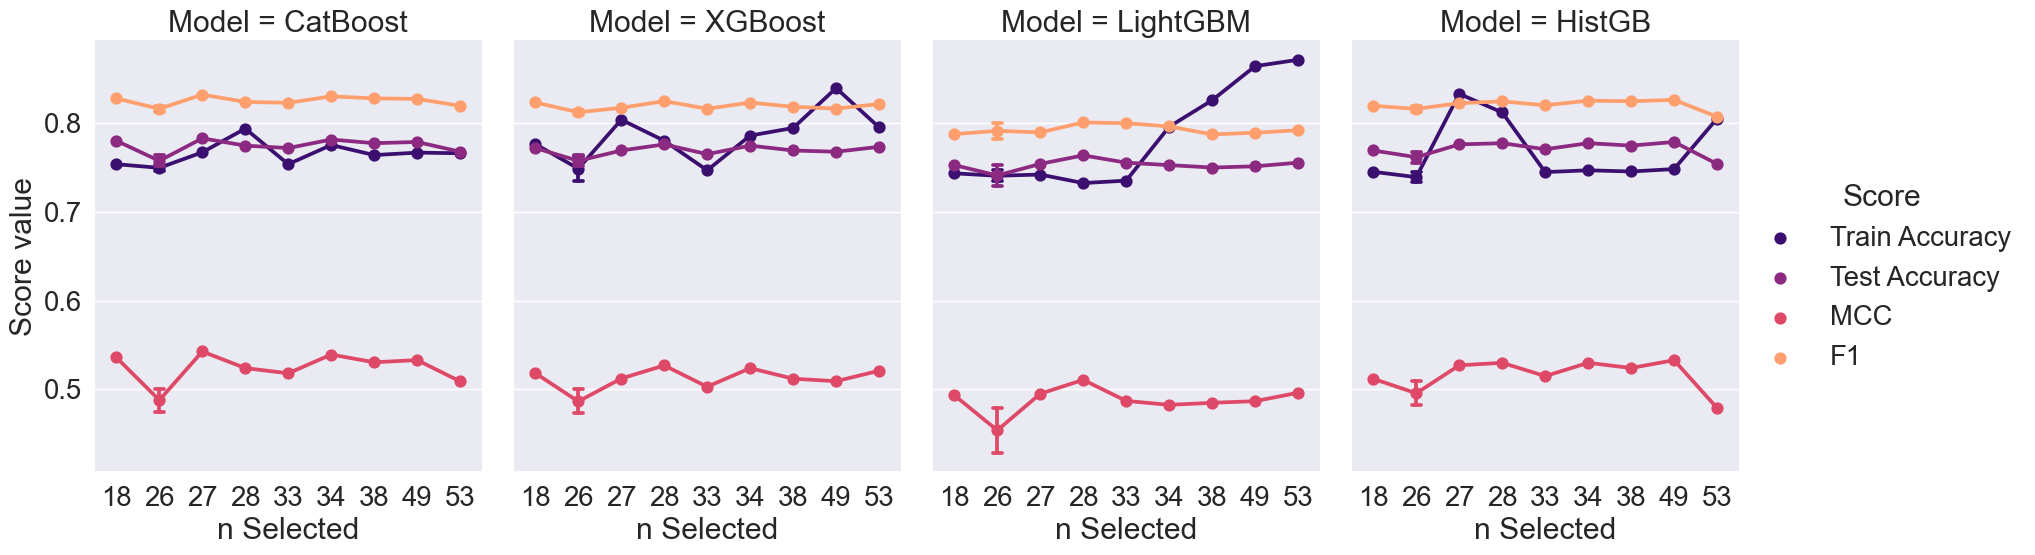

In [25]:
sns.set(rc={'figure.figsize':(20,20)})
sns.set_theme(style='whitegrid')
sns.set(font_scale=1.8)

g = sns.catplot(x="n Selected", y="Score value", hue="Score", col="Model",
                capsize=.2, palette="magma", height=6, aspect=.75,
                kind="point", data=results2)
g.despine(left=True)
plt.show()

In [26]:
best_train=results.groupby(['Model'], as_index=False).agg({'Train Accuracy': 'max'})
best_test=results.groupby(['Model'], as_index=False).agg({'Test Accuracy': 'max'})

max_test=[]
for m, a in best_test.values:
    max_test.append(results.loc[(results['Model']==m) & (results['Test Accuracy']==a) , results.columns].index.values[0])

max_train=[]
for m, a in best_train.values:
    max_train.append(results.loc[(results['Model']==m) & (results['Train Accuracy']==a) , results.columns].index.values[0])

**Confusion Matrix**

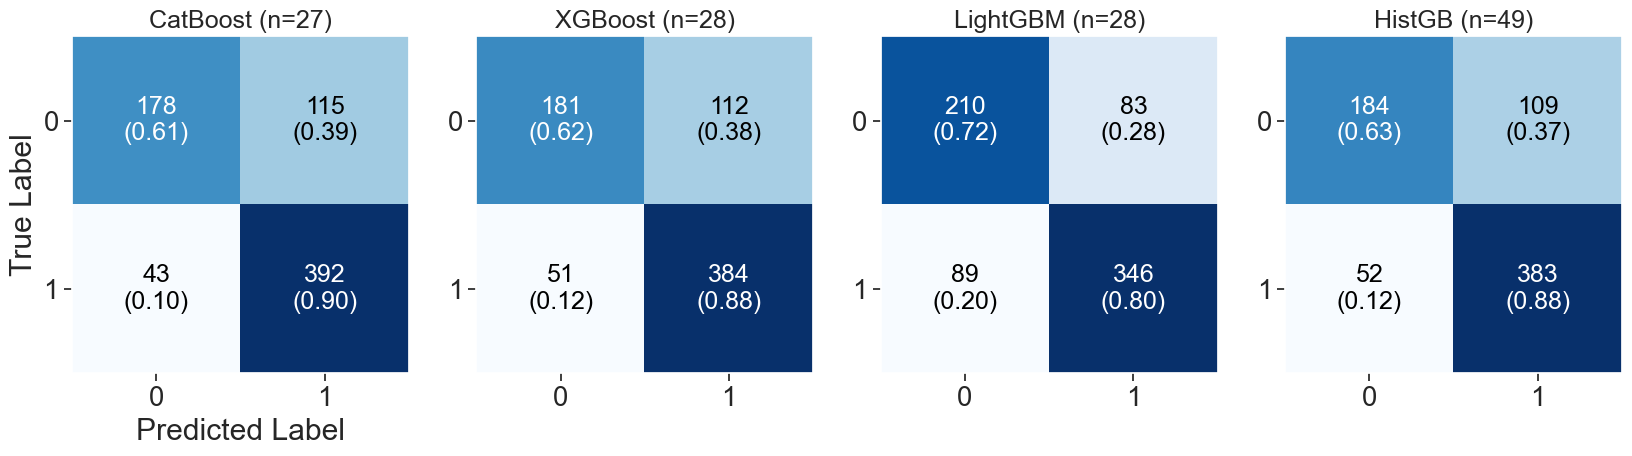

In [27]:
from mlxtend.plotting import plot_confusion_matrix
    
fig, axes=plt.subplots(1,4, figsize=(20,10))
sns.set(font_scale=1.5)

for idx, i in zip(sorted(max_test), range(len(max_test))):
    plot_confusion_matrix(axis=axes[i], conf_mat=results.loc[idx, 'conf_mat'], show_absolute=True, 
                                  show_normed=True)
    title='{} (n={:0.0f})'.format(results.loc[idx, 'Model'], results.loc[idx, 'n Selected'])
    axes[i].set(title=title)
    if (i > 0): axes[i].set(xlabel='', ylabel='')
    else : axes[i].set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

**Precision-Recall Curve**

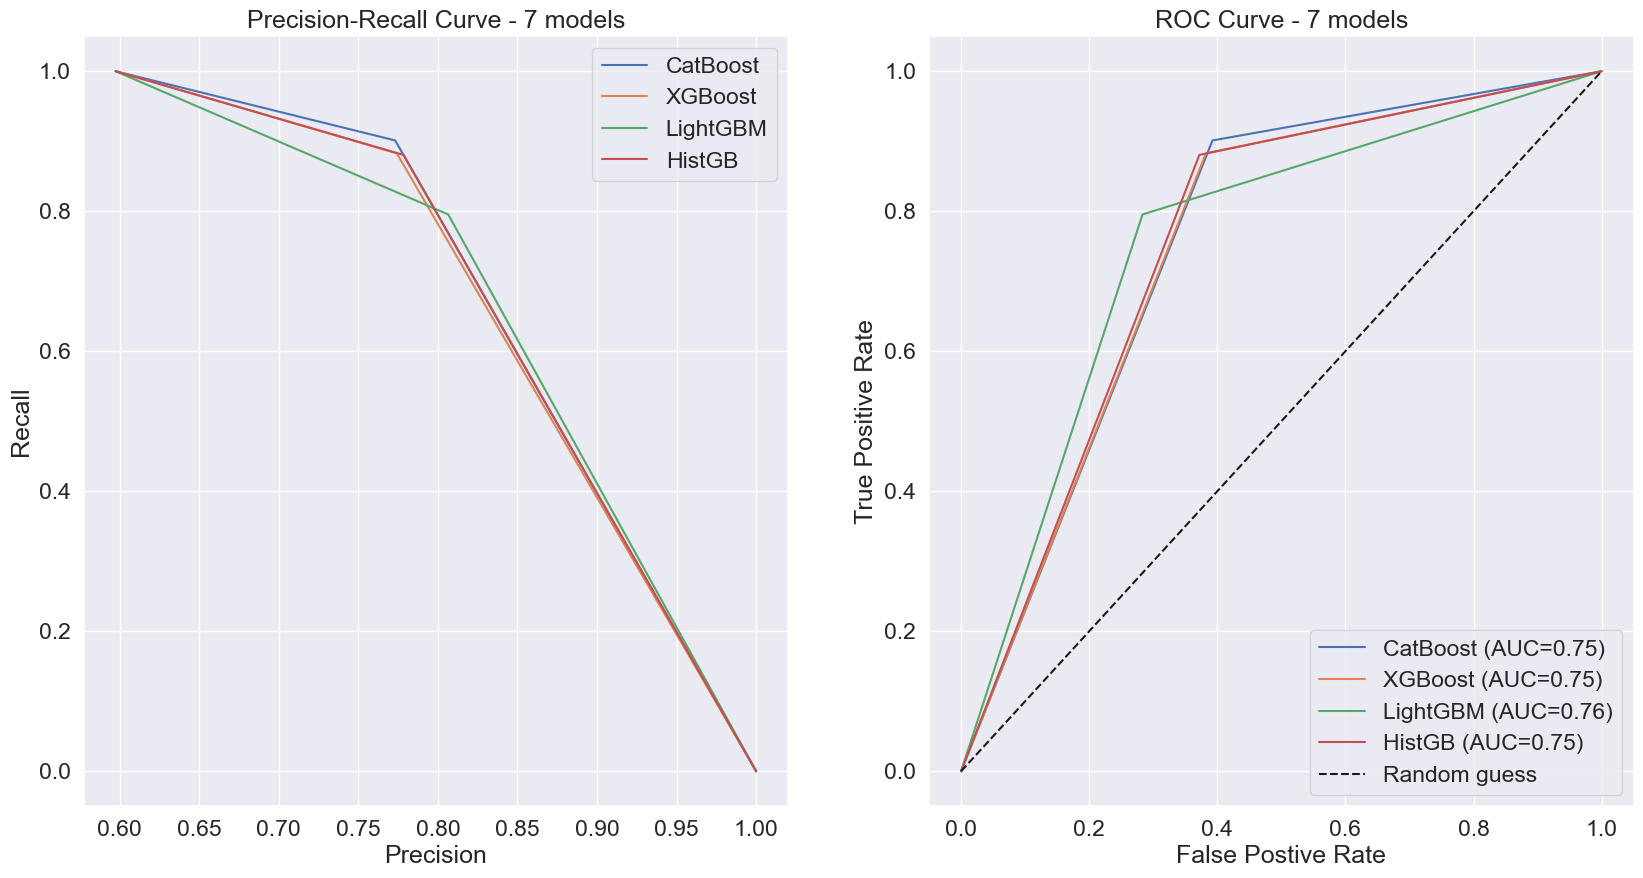

In [28]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc

fig, axes=plt.subplots(1,2, figsize=(20,10))

for idx in sorted(max_test):
    prec, rec, thr = precision_recall_curve(y_test, results.loc[idx, 'Prediction'])
    axes[0].plot(prec, rec, label=results.loc[idx, 'Model'])
axes[0].set(title='Precision-Recall Curve - 7 models', xlabel='Precision', ylabel='Recall')
axes[0].legend(loc="best")

for idx in sorted(max_test):
    fpr, tpr, thr = roc_curve(y_test, results.loc[idx, 'Prediction'])
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, label=results.loc[idx, 'Model']+' (AUC={:0.2f})'.format(roc_auc))
axes[1].plot([0, 1], [0, 1], 'k--', label='Random guess')
axes[1].set(title='ROC Curve - 7 models', xlabel='False Postive Rate', ylabel='True Positive Rate')
axes[1].legend(loc="best")

plt.show()

In [29]:
results.loc[max_test]

,Model,n Selected,Method,best_params,Best Accuracy,Train Accuracy,Test Accuracy,Precision,Recall,MCC,F1,conf_mat,Prediction,predict_proba,Features,estimator,classification_report,Train Time CPU,Train Time Wall,n_iter
3,CatBoost,27,Feature Importance - Random Forest,"{'random_strength': 10, 'min_data_in_leaf': 5,...",0.747591,0.767170,0.782967,0.773176,0.901149,0.542506,0.832272,"[[178, 115], [43, 392]]","[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","[[0.08762049271377381, 0.9123795072862262], [0...","[remain_teaching, public_pt_exp, public_ft_exp...",<catboost.core.CatBoostClassifier object at 0x...,precision recall f1-score ...,12.84375,426.697762,432
38,HistGB,49,RFE - Random Forest,"{'min_samples_leaf': 30, 'max_leaf_nodes': 50,...",0.741064,0.748283,0.778846,0.778455,0.880460,0.532703,0.826321,"[[184, 109], [52, 383]]","[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","[[0.08412308085315923, 0.9158769191468408], [0...","[remain_teaching, public_pt_exp, public_ft_exp...",HistGradientBoostingClassifier(categorical_fea...,precision recall f1-score ...,9.93750,73.017795,432
24,LightGBM,28,Permutation Importance - Random Forest,"{'reg_lambda': 0, 'reg_alpha': 0, 'n_estimator...",0.729737,0.732486,0.763736,0.806527,0.795402,0.510494,0.800926,"[[210, 83], [89, 346]]","[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, ...","[[0.15899834388639955, 0.8410016561136004], [0...","[remain_teaching, public_pt_exp, public_ft_exp...","LGBMClassifier(force_col_wise=True, is_unbalan...",precision recall f1-score ...,4.71875,20.923620,777
14,XGBoost,28,Permutation Importance - Random Forest,"{'n_estimators': 200, 'min_child_weight': 0, '...",0.744161,0.780220,0.776099,0.774194,0.882759,0.526748,0.824919,"[[181, 112], [51, 384]]","[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, ...","[[0.093740225, 0.9062598], [0.74957, 0.25043],...","[remain_teaching, public_pt_exp, public_ft_exp...","XGBClassifier(alpha=10, base_score=0.5, booste...",precision recall f1-score ...,26.03125,82.695045,777


In [30]:
results.sort_values(by=['Test Accuracy', 'MCC'], ascending=False).head(10)

,Model,n Selected,Method,best_params,Best Accuracy,Train Accuracy,Test Accuracy,Precision,Recall,MCC,F1,conf_mat,Prediction,predict_proba,Features,estimator,classification_report,Train Time CPU,Train Time Wall,n_iter
3,CatBoost,27,Feature Importance - Random Forest,"{'random_strength': 10, 'min_data_in_leaf': 5,...",0.747591,0.767170,0.782967,0.773176,0.901149,0.542506,0.832272,"[[178, 115], [43, 392]]","[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","[[0.08762049271377381, 0.9123795072862262], [0...","[remain_teaching, public_pt_exp, public_ft_exp...",<catboost.core.CatBoostClassifier object at 0x...,precision recall f1-score ...,12.843750,426.697762,432
6,CatBoost,34,Variance Threshold,"{'random_strength': 10, 'min_data_in_leaf': 1,...",0.742437,0.775412,0.781593,0.774900,0.894253,0.539061,0.830309,"[[180, 113], [46, 389]]","[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","[[0.07527619371102678, 0.9247238062889732], [0...","[remain_teaching, public_pt_exp, public_ft_exp...",<catboost.core.CatBoostClassifier object at 0x...,precision recall f1-score ...,10.031250,465.911640,432
0,CatBoost,18,RFE - Ridge,"{'random_strength': 15, 'min_data_in_leaf': 10...",0.743816,0.753777,0.780220,0.777778,0.885057,0.535739,0.827957,"[[183, 110], [50, 385]]","[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","[[0.08436008680280527, 0.9156399131971947], [0...","[remain_teaching, public_pt_exp, public_ft_exp...",<catboost.core.CatBoostClassifier object at 0x...,precision recall f1-score ...,5.843750,398.219199,432
8,CatBoost,49,RFE - Random Forest,"{'random_strength': 10, 'min_data_in_leaf': 5,...",0.741753,0.766827,0.778846,0.775100,0.887356,0.532820,0.827438,"[[181, 112], [49, 386]]","[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","[[0.11378501749659209, 0.8862149825034079], [0...","[remain_teaching, public_pt_exp, public_ft_exp...",<catboost.core.CatBoostClassifier object at 0x...,precision recall f1-score ...,8.625000,468.868284,432
38,HistGB,49,RFE - Random Forest,"{'min_samples_leaf': 30, 'max_leaf_nodes': 50,...",0.741064,0.748283,0.778846,0.778455,0.880460,0.532703,0.826321,"[[184, 109], [52, 383]]","[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","[[0.08412308085315923, 0.9158769191468408], [0...","[remain_teaching, public_pt_exp, public_ft_exp...",HistGradientBoostingClassifier(categorical_fea...,precision recall f1-score ...,9.937500,73.017795,432
7,CatBoost,38,Regularization - Lasso,"{'random_strength': 10, 'min_data_in_leaf': 1,...",0.742099,0.764080,0.777473,0.769231,0.896552,0.530322,0.828025,"[[176, 117], [45, 390]]","[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","[[0.05218813465682648, 0.9478118653431735], [0...","[remain_teaching, public_pt_exp, public_ft_exp...",<catboost.core.CatBoostClassifier object at 0x...,precision recall f1-score ...,11.265625,461.401695,432
34,HistGB,28,Permutation Importance - Random Forest,"{'min_samples_leaf': 10, 'max_leaf_nodes': 10,...",0.740725,0.812157,0.777473,0.779141,0.875862,0.529733,0.824675,"[[185, 108], [54, 381]]","[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, ...","[[0.08905025782817788, 0.9109497421718221], [0...","[remain_teaching, public_pt_exp, public_ft_exp...",HistGradientBoostingClassifier(categorical_fea...,precision recall f1-score ...,9.578125,51.412683,432
36,HistGB,34,Variance Threshold,"{'min_samples_leaf': 10, 'max_leaf_nodes': 31,...",0.744497,0.746909,0.777473,0.776876,0.880460,0.529713,0.825431,"[[183, 110], [52, 383]]","[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","[[0.07108790098395157, 0.9289120990160484], [0...","[remain_teaching, public_pt_exp, public_ft_exp...",HistGradientBoostingClassifier(categorical_fea...,precision recall f1-score ...,7.734375,58.742701,432
33,HistGB,27,Feature Importance - Random Forest,"{'min_samples_leaf': 10, 'max_leaf_nodes': 10,...",0.746557,0.833104,0.776099,0.780992,0.868966,0.526905,0.822633,"[[187, 106], [57, 378]]","[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","[[0.058084663424466165, 0.94191533657

In [31]:
results.to_csv('Modeling_GB.csv', index=False)